<a href="https://colab.research.google.com/github/Mengzhe/FreddieMacMortgageProject/blob/main/step2_5_FM_data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [20]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

import sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, 
                             roc_auc_score, 
                             average_precision_score)
from sklearn.model_selection import cross_val_score

from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import joblib
import pickle

# import shap
import warnings
import time
warnings.filterwarnings("ignore")

import json
from collections import defaultdict

from datetime import datetime
import pytz
from datetime import date

# from bayes_opt import BayesianOptimization

# trained_model_folder_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/LendingClub/trained_models/"

In [21]:
def extract_windows(array, clearing_time_index, max_time, sub_window_size):
    examples = []
    # start = clearing_time_index + 1 - sub_window_size + 1
    start = clearing_time_index - sub_window_size + 1

    for i in range(max_time+1):
        if start+sub_window_size+i<sub_window_size:
            example = np.zeros((sub_window_size, array.shape[1])) ## zero padding
            example[-(start+sub_window_size+i):] = array[:start+sub_window_size+i]
        else:
            example = array[start+i:start+sub_window_size+i]

        examples.append(np.expand_dims(example, 0))
    
    return np.vstack(examples)

In [22]:
def shift_yr_qtr(yr_qtr):
    year = int(yr_qtr[:2])
    q = int(yr_qtr[-1])
    q_sum = (year*4+q-1)-1
    year = q_sum//4
    q = q_sum%4+1
    return str(year)+'Q'+str(q)

def shift_yr_mth(yr_mth):
    year = int(yr_mth[:4])
    month = int(yr_mth[4:])
    mth_sum = (year*12+month-1)-1
    year = mth_sum//12
    month = mth_sum%12+1
    if month<10:
        return str(year)+'0'+str(month)
    else:
        return str(year)+str(month)



## Load data

##### Load data: orig, performance

In [23]:
dir_data = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/'
dir_data_orig = os.path.join(dir_data, 'data_orig_2011_2019_pre_chg_20210803_2235.csv')
dir_data_monthly = os.path.join(dir_data, 'data_monthly_2011_2019_pre_chg_20210803_2235.csv') 

print('dir_data_orig', dir_data_orig)
print('dir_data_monthly', dir_data_monthly)

dir_data_orig /content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/data_orig_2011_2019_pre_chg_20210803_2235.csv
dir_data_monthly /content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/data_monthly_2011_2019_pre_chg_20210803_2235.csv


In [24]:
df_orig = pd.read_csv(dir_data_orig, index_col=0)
df_monthly = pd.read_csv(dir_data_monthly, index_col=0)

print("df_orig.shape", df_orig.shape)
print("df_monthly.shape", df_monthly.shape)

df_orig.shape (20053, 19)
df_monthly.shape (1694602, 10)


In [25]:
df_orig['o_yr_qtr'] = df_orig['loan_id'].apply(lambda x: x[1:5])
## shift year and quarter since economic factors can have a quarter lag
df_orig['o_yr_qtr'] = df_orig['o_yr_qtr'].apply(shift_yr_qtr) 

df_orig['o_st_yr_qtr'] = df_orig['o_prop_st']+'_'+df_orig['o_yr_qtr']

In [26]:
df_orig.head()

,loan_id,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr
6,F11Q10001082,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4
7,F11Q10001104,201103,360,224000,0.0,80,4.375,R,N,0,710,unknown,33,1,1,P,OR,SF,9,10Q4,OR_10Q4
9,F11Q10001291,201103,360,165000,30.0,95,4.375,R,N,0,739,unknown,29,2,1,P,NC,SF,9,10Q4,NC_10Q4
11,F11Q10001944,201103,360,144000,0.0,72,4.625,R,C,0,769,unknown,23,2,1,P,IL,SF,9,10Q4,IL_10Q4
12,F11Q10002098,201103,360,142000,0.0,77,4.625,R,N,0,784,unknown,20,2,1,P,NE,SF,9,10Q4,NE_10Q4


In [27]:
df_orig['o_yr_qtr_shifted'] = df_orig['o_yr_qtr'].apply(shift_yr_qtr)
df_orig.sample(100).head()

,loan_id,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted
30214,F12Q30292678,201211,360,259000,30.0,95,4.000,R,P,0,718,N,44,2,1,P,OH,SF,9,12Q2,OH_12Q2,12Q1
23783,F12Q20371460,201208,360,225000,0.0,37,3.875,B,C,0,778,unknown,24,1,1,P,IL,SF,9,12Q1,IL_12Q1,11Q4
69898,F16Q30091470,201609,360,308000,30.0,95,3.875,R,P,0,779,Y,23,2,1,P,TX,PU,9,16Q2,TX_16Q2,16Q1
63384,F14Q40159606,201502,360,114000,30.0,95,4.125,R,P,0,791,N,33,1,1,P,IN,SF,9,14Q3,IN_14Q3,14Q2
71725,F17Q20236130,201707,360,207000,0.0,51,4.500,R,C,0,666,unknown,37,2,1,P,TX,SF,2,17Q1,TX_17Q1,16Q4


In [28]:
us_states = set(sorted(df_orig['o_prop_st'].unique().tolist()))

In [29]:
## merge
df_combined = pd.merge(df_monthly, df_orig, on='loan_id')
df_combined.sort_values(by=['loan_id', 'loan_age'], inplace=True)

df_combined['rep_period'] = df_combined['rep_period'].astype(str)
## shift rep_period 
df_combined['shifted_rep_period'] = df_combined['rep_period'].apply(shift_yr_mth)

## all date-related information are shifted by one month
## so that the lags of economic factors are considered, i.e., one-month or one-quarter lag
df_combined['o_rep_period'] = df_combined.groupby('loan_id').transform('first')['shifted_rep_period']
df_combined['o_st_rep_period'] = df_combined['o_prop_st']+'_'+df_combined['o_rep_period'].astype(str)

df_combined['st_rep_period'] = df_combined['o_prop_st']+'_'+df_combined['shifted_rep_period'].astype(str)
df_combined['rep_yr_qtr'] = df_combined['rep_period'].astype(str).apply(lambda x: x[2:4]+'Q'+str(((int(x[-2:])-1)//3)+1))
df_combined['rep_yr_qtr'] = df_combined['rep_yr_qtr'].apply(shift_yr_qtr)
df_combined['st_rep_yr_qtr'] = df_combined['o_prop_st'] + '_' + df_combined['rep_yr_qtr']

df_combined.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted,shifted_rep_period,o_rep_period,o_st_rep_period,st_rep_period,rep_yr_qtr,st_rep_yr_qtr
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201101,201101,OR_201101,OR_201101,10Q4,OR_10Q4
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201102,201101,OR_201101,OR_201102,10Q4,OR_10Q4
2,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201103,201101,OR_201101,OR_201103,11Q1,OR_11Q1
3,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201104,201101,OR_201101,OR_201104,11Q1,OR_11Q1
4,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201105,201101,OR_201101,OR_201105,11Q1,OR_11Q1


##### Load data: house price index 

In [30]:
dir_hpi = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/house_index_history/HPI_PO_state.xls'
df_hpi = pd.read_excel(dir_hpi)
df_hpi['st_rep_yr_qtr'] = df_hpi['state']+'_'+df_hpi['yr'].apply(lambda x: str(x)[-2:])+'Q'+df_hpi['qtr'].apply(lambda x: str(x))
df_hpi.drop(columns=['Warning', 'index_nsa'], inplace=True)
df_hpi.rename(columns={'index_sa': 'hpi'}, inplace=True)
df_hpi.reset_index(inplace=True, drop=True)
df_hpi.sort_values(by=['state', 'yr', 'qtr'], inplace=True)
df_hpi.drop(columns=['state', 'yr', 'qtr'], inplace=True)

df_hpi

,hpi,st_rep_yr_qtr
0,100.00,AK_91Q1
1,100.41,AK_91Q2
2,101.33,AK_91Q3
3,102.35,AK_91Q4
4,102.68,AK_92Q1
...,...,...
6166,376.17,WY_20Q1
6167,374.26,WY_20Q2
6168,383.05,WY_20Q3
6169,395.14,WY_20Q4


##### Load data: unemployment rate history

In [31]:
startyears = [2000, 2010, 2020]
endyears = [2009, 2019, 2021]
# dir_ue = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_2011_2020.csv'
df_ue_list = []
for startyear, endyear in zip(startyears, endyears):
    dir_ue = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_{startyear}_{endyear}.csv'.format(startyear=startyear, 
                                                                                                                                                    endyear=endyear)
    print(dir_ue)
    df_ue = pd.read_csv(dir_ue)
    df_ue_list.append(df_ue)

df_ue = pd.concat(df_ue_list, ignore_index=True)  
df_ue.drop(columns=['series_id', 'year', 'month', 'st', 'rep_period'], inplace=True)
df_ue.head()


/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_2000_2009.csv
/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_2010_2019.csv
/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_2020_2021.csv


,ue_rate,st_rep_period
0,11.1,AL_200912
1,11.0,AL_200911
2,10.9,AL_200910
3,10.8,AL_200909
4,10.6,AL_200908


##### Load data: Charge-Off Rate on Single Family Residential Mortgages, Booked in Domestic Offices, Top 100 Banks Ranked by Assets
https://fred.stlouisfed.org/series/CORSFRMT100N

,charge_off_rate,rep_yr_qtr
0,0.17,91Q1
1,0.13,91Q2
2,0.16,91Q3
3,0.15,91Q4
4,0.21,92Q1


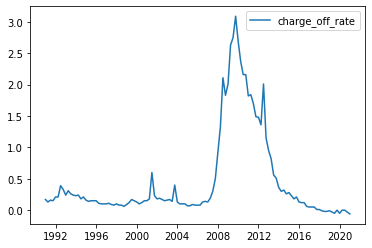

In [32]:
dir_chgoff = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/FRED_mortgage_rate_data/Charge-Off Rate on Single Family Residential Mortgages, Booked in Domestic Offices, Top 100 Banks Ranked by Assets.xlsx'
df_chgoff = pd.read_excel(dir_chgoff)
df_chgoff['observation_date'] = pd.to_datetime(df_chgoff['observation_date'])
df_chgoff['rep_yr_qtr'] = df_chgoff['observation_date'].apply(lambda x: str(x.year)[-2:])+'Q'+df_chgoff['observation_date'].apply(lambda x: str(x.quarter))
df_chgoff.rename(columns={'CORSFRMT100S': 'charge_off_rate'}, inplace=True)
plt.plot(df_chgoff['observation_date'], df_chgoff['charge_off_rate'], label='charge_off_rate')
plt.legend()

df_chgoff.drop(columns=['observation_date'], inplace=True)
df_chgoff.head()


##### Delinquency Rate on Single-Family Residential Mortgages, Booked in Domestic Offices, All Commercial Banks
https://fred.stlouisfed.org/series/DRSFRMACBS

,dlq_rate,rep_yr_qtr
0,3.10,91Q1
1,3.17,91Q2
2,3.23,91Q3
3,3.29,91Q4
4,3.13,92Q1


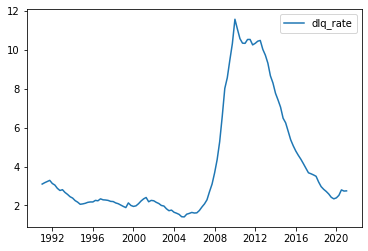

In [33]:
dir_dlq = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/FRED_mortgage_rate_data/Delinquency Rate on Single-Family Residential Mortgages, Booked in Domestic Offices, All Commercial Banks.xlsx'
df_dlq = pd.read_excel(dir_dlq)
df_dlq['observation_date'] = pd.to_datetime(df_dlq['observation_date'])
df_dlq['rep_yr_qtr'] = df_dlq['observation_date'].apply(lambda x: str(x.year)[-2:])+'Q'+df_dlq['observation_date'].apply(lambda x: str(x.quarter))
df_dlq.rename(columns={'DRSFRMACBS': 'dlq_rate'}, inplace=True)
plt.plot(df_dlq['observation_date'], df_dlq['dlq_rate'], label='dlq_rate')
plt.legend()

df_dlq.drop(columns=['observation_date'], inplace=True)
df_dlq.head()


##### 30-Year Fixed Rate Mortgage Average in the United States
https://fred.stlouisfed.org/series/MORTGAGE30US

,avg_frm,rep_period
0,7.29,197104
1,7.46,197105
2,7.54,197106
3,7.69,197107
4,7.69,197108


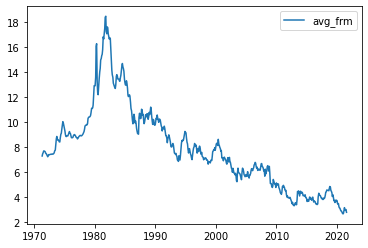

In [34]:
dir_mort_rate = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/FRED_mortgage_rate_data/30-Year Fixed Rate Mortgage Average in the United States.xlsx'
df_mort_rate = pd.read_excel(dir_mort_rate)
df_mort_rate['observation_date'] = pd.to_datetime(df_mort_rate['observation_date'])
df_mort_rate.sort_values(by='observation_date', inplace=True)
df_mort_rate['rep_period'] = df_mort_rate['observation_date'].dt.year.astype(str)+df_mort_rate['observation_date'].apply(lambda x: '0'+str(x.month) if x.month<10 else str(x.month))
df_mort_rate = df_mort_rate.groupby('rep_period').apply(lambda x: x.tail(1))
df_mort_rate.reset_index(inplace=True, drop=True)
df_mort_rate.rename(columns={'MORTGAGE30US': 'avg_frm'}, inplace=True)
plt.plot(df_mort_rate['observation_date'], df_mort_rate['avg_frm'], label='avg_frm')
plt.legend()

df_mort_rate.drop(columns=['observation_date'], inplace=True)
df_mort_rate.head()

##### State Leve Mortgage Performance Statistics
https://www.fhfa.gov/DataTools/Downloads/Pages/National-Mortgage-Database-Aggregate-Data.aspx

In [35]:
dir_st_co_dlq = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/FRED_mortgage_rate_data/State_Level_Mortgage_Performance_Statistics.xlsx'
df_list = []
for st in us_states:
    try:
        df_st_co_dlq = pd.read_excel(dir_st_co_dlq, 
                                    sheet_name=st, 
                                    skiprows=4,
                                    header=1,
                                    skipfooter=2)
        df_st_co_dlq['st_rep_yr_qtr'] = st+'_'+df_st_co_dlq['Quarter'].astype(str).apply(lambda x: x[-4:])
        df_list.append(df_st_co_dlq)
        # break
    except:
        pass

df_st_co_dlq = pd.concat(df_list, ignore_index=True)  
df_st_co_dlq.drop(columns=['Quarter', 'Percent in Forbearance'], inplace=True)
df_st_co_dlq.rename(columns={'Percent 30 or 60 Days Past Due Date': 'pct_3060dpd', 
                             'Percent 90 to 180 Days Past Due Date': 'pct_90180dpd', 
                             'Percent in the Process of Foreclosure, Bankruptcy, or Deed in Lieu': 'pct_fcl'}, 
                    inplace=True)
df_st_co_dlq.dropna(axis=0, inplace=True)
df_st_co_dlq.head()


,pct_3060dpd,pct_90180dpd,pct_fcl,st_rep_yr_qtr
0,2.8,1.2,3.2,ID_02Q1
1,2.4,1.1,3.2,ID_02Q2
2,2.8,1.2,3.3,ID_02Q3
3,3.6,1.1,3.7,ID_02Q4
4,3.4,1.2,3.7,ID_03Q1


## Merge data

#### House index history data

In [36]:
## hpi (quarterly updated) 
df_combined_hpi = pd.merge(df_combined, df_hpi, left_on='st_rep_yr_qtr', right_on='st_rep_yr_qtr')
df_combined_hpi.sort_values(by=['loan_id', 'loan_age'], inplace=True)

## hpi (origination date) 
df_combined_hpi['o_hpi'] = df_combined_hpi.groupby('loan_id').transform('first')['hpi']

df_combined_hpi.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted,shifted_rep_period,o_rep_period,o_st_rep_period,st_rep_period,rep_yr_qtr,st_rep_yr_qtr,hpi,o_hpi
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201101,201101,OR_201101,OR_201101,10Q4,OR_10Q4,252.46,252.46
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201102,201101,OR_201101,OR_201102,10Q4,OR_10Q4,252.46,252.46
26,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201103,201101,OR_201101,OR_201103,11Q1,OR_11Q1,245.77,252.46
27,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201104,201101,OR_201101,OR_201104,11Q1,OR_11Q1,245.77,252.46
28,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201105,201101,OR_201101,OR_201105,11Q1,OR_11Q1,245.77,252.46


In [37]:
del df_combined

#### Unemployment rate

In [38]:
## monthly unemployment rate
df_combined_ue = pd.merge(df_combined_hpi, 
                          df_ue, 
                          left_on='st_rep_period', 
                          right_on='st_rep_period')
df_combined_ue.sort_values(by=['loan_id', 'loan_age'], inplace=True)

## unemployment rate on origination date
df_combined_ue['o_ue_rate'] = df_combined_ue.groupby('loan_id').transform('first')['ue_rate']

In [39]:
df_combined_ue[['ue_rate', 'o_ue_rate']].describe()

,ue_rate,o_ue_rate
count,929405.000000,929405.000000
mean,5.622755,7.342593
std,2.027987,1.974799
min,2.000000,2.000000
25%,4.200000,5.800000
50%,5.200000,7.300000
75%,6.600000,8.900000
max,29.500000,13.700000


In [40]:
del df_combined_hpi

#### Charge-Off Rate on Single Family Residential Mortgages, Booked in Domestic Offices, Top 100 Banks Ranked by Assets

In [41]:
df_combined_co = pd.merge(df_combined_ue, 
                          df_chgoff, 
                          left_on='rep_yr_qtr', 
                          right_on='rep_yr_qtr')
df_combined_co.sort_values(by=['loan_id', 'loan_age'], inplace=True)
df_combined_co.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted,shifted_rep_period,o_rep_period,o_st_rep_period,st_rep_period,rep_yr_qtr,st_rep_yr_qtr,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201101,201101,OR_201101,OR_201101,10Q4,OR_10Q4,252.46,252.46,10.1,10.1,2.16
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201102,201101,OR_201101,OR_201102,10Q4,OR_10Q4,252.46,252.46,9.8,10.1,2.16
1279,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201103,201101,OR_201101,OR_201103,11Q1,OR_11Q1,245.77,252.46,9.7,10.1,1.82
1280,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201104,201101,OR_201101,OR_201104,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82
1281,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201105,201101,OR_201101,OR_201105,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82


In [42]:
del df_combined_ue

#### Delinquency Rate on Single-Family Residential Mortgages, Booked in Domestic Offices, All Commercial Banks

In [43]:
df_combined_dlq = pd.merge(df_combined_co, 
                           df_dlq, 
                           left_on='rep_yr_qtr', 
                           right_on='rep_yr_qtr')
df_combined_dlq.sort_values(by=['loan_id', 'loan_age'], inplace=True)
df_combined_dlq.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted,shifted_rep_period,o_rep_period,o_st_rep_period,st_rep_period,rep_yr_qtr,st_rep_yr_qtr,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201101,201101,OR_201101,OR_201101,10Q4,OR_10Q4,252.46,252.46,10.1,10.1,2.16,10.35
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201102,201101,OR_201101,OR_201102,10Q4,OR_10Q4,252.46,252.46,9.8,10.1,2.16,10.35
1279,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201103,201101,OR_201101,OR_201103,11Q1,OR_11Q1,245.77,252.46,9.7,10.1,1.82,10.34
1280,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201104,201101,OR_201101,OR_201104,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82,10.34
1281,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201105,201101,OR_201101,OR_201105,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82,10.34


In [44]:
del df_combined_co

#### 30-Year Fixed Rate Mortgage Average in the United States

In [45]:
df_combined_frm = pd.merge(df_combined_dlq, 
                           df_mort_rate, 
                           left_on='rep_period', 
                           right_on='rep_period')
df_combined_frm.sort_values(by=['loan_id', 'loan_age'], inplace=True)
df_combined_frm['o_avg_frm'] = df_combined_frm.groupby('loan_id').transform('first')['avg_frm']


In [46]:
df_combined_frm.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted,shifted_rep_period,o_rep_period,o_st_rep_period,st_rep_period,rep_yr_qtr,st_rep_yr_qtr,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201101,201101,OR_201101,OR_201101,10Q4,OR_10Q4,252.46,252.46,10.1,10.1,2.16,10.35,4.95,4.95
483,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201102,201101,OR_201101,OR_201102,10Q4,OR_10Q4,252.46,252.46,9.8,10.1,2.16,10.35,4.86,4.95
1279,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201103,201101,OR_201101,OR_201103,11Q1,OR_11Q1,245.77,252.46,9.7,10.1,1.82,10.34,4.78,4.95
2492,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201104,201101,OR_201101,OR_201104,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82,10.34,4.60,4.95
4041,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201105,201101,OR_201101,OR_201105,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82,10.34,4.51,4.95


In [47]:
del df_combined_dlq

#### State Level Mortgage Performance Statistics

In [48]:
df_combined_co_dlq = pd.merge(df_combined_frm, 
                           df_st_co_dlq, 
                           left_on='st_rep_yr_qtr', 
                           right_on='st_rep_yr_qtr')
df_combined_co_dlq.sort_values(by=['loan_id', 'loan_age'], inplace=True)
df_combined_co_dlq['o_pct_fcl'] = df_combined_co_dlq.groupby('loan_id').transform('first')['pct_fcl']


In [49]:
df_combined_co_dlq.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted,shifted_rep_period,o_rep_period,o_st_rep_period,st_rep_period,rep_yr_qtr,st_rep_yr_qtr,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm,pct_3060dpd,pct_90180dpd,pct_fcl,o_pct_fcl
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201101,201101,OR_201101,OR_201101,10Q4,OR_10Q4,252.46,252.46,10.1,10.1,2.16,10.35,4.95,4.95,4.7,7.1,6.0,6.0
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201102,201101,OR_201101,OR_201102,10Q4,OR_10Q4,252.46,252.46,9.8,10.1,2.16,10.35,4.86,4.95,4.7,7.1,6.0,6.0
26,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201103,201101,OR_201101,OR_201103,11Q1,OR_11Q1,245.77,252.46,9.7,10.1,1.82,10.34,4.78,4.95,4.8,7.9,5.3,6.0
27,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201104,201101,OR_201101,OR_201104,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82,10.34,4.60,4.95,4.8,7.9,5.3,6.0
28,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201105,201101,OR_201101,OR_201105,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82,10.34,4.51,4.95,4.8,7.9,5.3,6.0


In [50]:
del df_combined_frm

## Preprocess

#### Copy data

In [51]:
df = df_combined_co_dlq.drop(columns=['o_yr_qtr', 'o_st_yr_qtr', 'o_yr_qtr_shifted',
                                    'shifted_rep_period', 'o_rep_period',
                                    'o_st_rep_period', 'st_rep_period', 
                                    'rep_yr_qtr', 'st_rep_yr_qtr',])
df.sort_values(by=['loan_id', 'loan_age'], inplace=True)
df.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm,pct_3060dpd,pct_90180dpd,pct_fcl,o_pct_fcl
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,252.46,252.46,10.1,10.1,2.16,10.35,4.95,4.95,4.7,7.1,6.0,6.0
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,252.46,252.46,9.8,10.1,2.16,10.35,4.86,4.95,4.7,7.1,6.0,6.0
26,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,245.77,252.46,9.7,10.1,1.82,10.34,4.78,4.95,4.8,7.9,5.3,6.0
27,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,245.77,252.46,9.6,10.1,1.82,10.34,4.60,4.95,4.8,7.9,5.3,6.0
28,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,245.77,252.46,9.6,10.1,1.82,10.34,4.51,4.95,4.8,7.9,5.3,6.0


In [52]:
del df_combined_co_dlq

#### Create monthly features

since est_ltv from the dataset have many missing values, the following estimation is used: 
$$est\_ltv = \dfrac{upb}{o\_upb}*\dfrac{o\_hpi}{hpi}*o\_ltv$$

In [53]:
try:
    df['est_ltv'] = (df['actual_upb']/df['o_upb'])*(df['o_hpi']/df['hpi'])*df['o_ltv']
    df['upb_pct'] = df['actual_upb'] / df['o_upb']
    df['age_pct'] = df['loan_age'] / df['o_term']
    df.drop(columns=['o_term', 'o_pt_val_md'], inplace=True, errors='ignored') ## all mortgage are 30-year
except:
    pass

df.shape

(929405, 40)

In [54]:
df[['upb_pct', 'est_ltv', 'age_pct']].corr()

,upb_pct,est_ltv,age_pct
upb_pct,1.000000,0.647899,-0.375701
est_ltv,0.647899,1.000000,-0.521933
age_pct,-0.375701,-0.521933,1.000000


## Data Visualization

In [55]:
selected_states = ['CA', 'TX', 'IL', 'FL', 'VA']

#### Example data

In [56]:
orig_cols = ['loan_id', 'o_term', 'o_upb', 'o_ltv', 'o_int_rate', 'o_credit_score', 
             'o_dti', 'o_prop_st', 'o_prop_type', 'o_occ_stat',
             'o_first_flag', 'o_num_brwrs', 'o_units',  'o_purp', 
             'o_mi', 'o_chan', 'o_ind_sup_cfm', ]

In [57]:
example_loan_id = "F11Q10001082"
df_orig.loc[df_orig['loan_id']==example_loan_id, orig_cols]

,loan_id,o_term,o_upb,o_ltv,o_int_rate,o_credit_score,o_dti,o_prop_st,o_prop_type,o_occ_stat,o_first_flag,o_num_brwrs,o_units,o_purp,o_mi,o_chan,o_ind_sup_cfm
6,F11Q10001082,360,261000,90,4.375,767,39,OR,SF,P,unknown,1,1,N,25.0,R,0


In [58]:
df_monthly.loc[df_monthly['loan_id']==example_loan_id, :]

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster
496,F11Q10001082,201102,261000.00,0,0,360,NaN,4.375,NaN,0
497,F11Q10001082,201103,261000.00,0,1,359,NaN,4.375,NaN,0
498,F11Q10001082,201104,260000.00,0,2,358,NaN,4.375,NaN,0
499,F11Q10001082,201105,260000.00,0,3,357,NaN,4.375,NaN,0
500,F11Q10001082,201106,260000.00,0,4,356,NaN,4.375,NaN,0
...,...,...,...,...,...,...,...,...,...,...
591,F11Q10001082,201901,219033.87,0,95,265,NaN,4.375,42.0,0
592,F11Q10001082,201902,218529.30,0,96,264,NaN,4.375,42.0,0
593,F11Q10001082,201903,218022.89,0,97,263,NaN,4.375,41.0,0
594,F11Q10001082,201904,217514.64,0,98,262,NaN,4.375,41.0,0


In [59]:
save_path = "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/web_presentation"

In [60]:
df_monthly_example = df_monthly.loc[df_monthly['loan_id']==example_loan_id, :].to_csv(os.path.join(save_path, 
                                                                                                   "DataExample_monthly.csv"))

#### Prepare data

In [61]:
df.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm,pct_3060dpd,pct_90180dpd,pct_fcl,o_pct_fcl,upb_pct,age_pct
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,90.000000,0,201103,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,252.46,252.46,10.1,10.1,2.16,10.35,4.95,4.95,4.7,7.1,6.0,6.0,1.000000,0.000000
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,90.000000,0,201103,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,252.46,252.46,9.8,10.1,2.16,10.35,4.86,4.95,4.7,7.1,6.0,6.0,1.000000,0.002778
26,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,92.095637,0,201103,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,245.77,252.46,9.7,10.1,1.82,10.34,4.78,4.95,4.8,7.9,5.3,6.0,0.996169,0.005556
27,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,92.095637,0,201103,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,245.77,252.46,9.6,10.1,1.82,10.34,4.60,4.95,4.8,7.9,5.3,6.0,0.996169,0.008333
28,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,92.095637,0,201103,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,245.77,252.46,9.6,10.1,1.82,10.34,4.51,4.95,4.8,7.9,5.3,6.0,0.996169,0.011111


In [62]:
df['zero_bal_code'].value_counts()

1.0    16725
2.0     2379
3.0      945
Name: zero_bal_code, dtype: int64

In [63]:
df_zb_row = df.loc[~df['zero_bal_code'].isnull(), :]
df_zb_row['zero_bal_code'] = df_zb_row['zero_bal_code'].apply(np.int)
df_zb_row.loc[df_zb_row['zero_bal_code']==1, 'zero_bal_code'] = 0
df_zb_row.loc[df_zb_row['zero_bal_code']!=0, 'zero_bal_code'] = 1
mapping_zb_code = {0: 'Paid off', 1: 'Charge off'}
df_zb_row

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm,pct_3060dpd,pct_90180dpd,pct_fcl,o_pct_fcl,upb_pct,age_pct
13363,F11Q10001082,201905,0.0,0,99,261,0,4.375,0.0,0,201103,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,428.96,252.46,3.9,10.1,-0.01,2.72,3.99,4.95,1.4,0.9,0.6,6.0,0.0,0.275000
8492,F11Q10001104,201609,0.0,0,67,293,0,4.375,0.0,0,201103,224000,0.0,80,4.375,R,N,0,710,unknown,33,1,1,P,OR,SF,357.14,252.46,4.8,10.1,0.12,4.58,3.42,4.95,1.8,3.0,2.0,6.0,0.0,0.186111
42529,F11Q10001291,202005,0.0,0,111,249,0,4.375,0.0,0,201103,165000,30.0,95,4.375,R,N,0,739,unknown,29,2,1,P,NC,SF,263.90,180.70,13.5,10.4,-0.05,2.39,3.15,4.95,3.3,1.5,0.9,4.0,0.0,0.308333
49253,F11Q10001944,201304,0.0,0,26,334,0,4.625,0.0,0,201103,144000,0.0,72,4.625,R,C,0,769,unknown,23,2,1,P,IL,SF,166.20,172.38,9.3,9.6,0.95,9.73,3.40,4.95,4.1,6.3,5.6,6.5,0.0,0.072222
50950,F11Q10002098,201209,0.0,0,19,341,0,4.625,0.0,0,201103,142000,0.0,77,4.625,R,N,0,784,unknown,20,2,1,P,NE,SF,193.55,186.93,3.8,4.6,1.36,10.45,3.40,4.95,2.9,2.7,1.7,1.7,0.0,0.052778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909143,F19Q40061459,202005,0.0,0,6,354,0,4.000,0.0,0,201912,268000,0.0,78,4.000,R,C,0,728,unknown,37,2,1,P,AZ,PU,354.70,338.55,14.2,4.7,-0.05,2.39,3.15,3.68,2.2,0.9,0.3,0.6,0.0,0.016667
868376,F19Q40152198,202010,0.0,0,11,349,1,4.500,0.0,0,201912,110000,0.0,70,4.500,R,N,0,629,unknown,36,1,1,P,MO,SF,270.96,246.82,5.4,3.4,0.00,2.80,2.81,3.68,1.7,0.9,0.7,1.0,0.0,0.030556
916912,F19Q40205065,202010,0.0,0,10,350,0,3.500,0.0,0,202001,415000,0.0,77,3.500,R,C,0,741,unknown,34,1,1,P,CO,PU,515.14,478.38,7.0,2.5,0.00,2.80,2.81,3.74,0.8,0.5,0.2,0.3,0.0,0.027778
764206,F19Q40234780,202010,0.0,0,10,350,1,4.125,0.0,0,202001,218000,18.0,97,4.125,C,P,0,806,Y,41,1,1,P,CA,SF,312.37,290.92,10.6,4.1,0.00,2.80,2.81,3.74,0.7,0.5,0.2,0.2,0.0,0.027778


In [64]:
df_zb_row['zero_bal_code'].value_counts()

0    16725
1     3324
Name: zero_bal_code, dtype: int64

#### Loan Counts by Years (Origination)

In [84]:
df_zb_row['year'] = '20' + df_zb_row['loan_id'].apply(lambda x: x[1:3])
df_zb_row

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm,pct_3060dpd,pct_90180dpd,pct_fcl,o_pct_fcl,upb_pct,age_pct,year
13363,F11Q10001082,201905,0.0,0,99,261,0,4.375,0.0,0,201103,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,428.96,252.46,3.9,10.1,-0.01,2.72,3.99,4.95,1.4,0.9,0.6,6.0,0.0,0.275000,2011
8492,F11Q10001104,201609,0.0,0,67,293,0,4.375,0.0,0,201103,224000,0.0,80,4.375,R,N,0,710,unknown,33,1,1,P,OR,SF,357.14,252.46,4.8,10.1,0.12,4.58,3.42,4.95,1.8,3.0,2.0,6.0,0.0,0.186111,2011
42529,F11Q10001291,202005,0.0,0,111,249,0,4.375,0.0,0,201103,165000,30.0,95,4.375,R,N,0,739,unknown,29,2,1,P,NC,SF,263.90,180.70,13.5,10.4,-0.05,2.39,3.15,4.95,3.3,1.5,0.9,4.0,0.0,0.308333,2011
49253,F11Q10001944,201304,0.0,0,26,334,0,4.625,0.0,0,201103,144000,0.0,72,4.625,R,C,0,769,unknown,23,2,1,P,IL,SF,166.20,172.38,9.3,9.6,0.95,9.73,3.40,4.95,4.1,6.3,5.6,6.5,0.0,0.072222,2011
50950,F11Q10002098,201209,0.0,0,19,341,0,4.625,0.0,0,201103,142000,0.0,77,4.625,R,N,0,784,unknown,20,2,1,P,NE,SF,193.55,186.93,3.8,4.6,1.36,10.45,3.40,4.95,2.9,2.7,1.7,1.7,0.0,0.052778,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909143,F19Q40061459,202005,0.0,0,6,354,0,4.000,0.0,0,201912,268000,0.0,78,4.000,R,C,0,728,unknown,37,2,1,P,AZ,PU,354.70,338.55,14.2,4.7,-0.05,2.39,3.15,3.68,2.2,0.9,0.3,0.6,0.0,0.016667,2019
868376,F19Q40152198,202010,0.0,0,11,349,1,4.500,0.0,0,201912,110000,0.0,70,4.500,R,N,0,629,unknown,36,1,1,P,MO,SF,270.96,246.82,5.4,3.4,0.00,2.80,2.81,3.68,1.7,0.9,0.7,1.0,0.0,0.030556,2019
916912,F19Q40205065,202010,0.0,0,10,350,0,3.500,0.0,0,202001,415000,0.0,77,3.500,R,C,0,741,unknown,34,1,1,P,CO,PU,515.14,478.38,7.0,2.5,0.00,2.80,2.81,3.74,0.8,0.5,0.2,0.3,0.0,0.027778,2019
764206,F19Q40234780,202010,0.0,0,10,350,1,4.125,0.0,0,202001,218000,18.0,97,4.125,C,P,0,806,Y,41,1,1,P,CA,SF,312.37,290.92,10.6,4.1,0.00,2.80,2.81,3.74,0.7,0.5,0.2,0.2,0.0,0.027778,2019


In [92]:
# df_zb_row.groupby('year').apply(len)
df_year_zbc = pd.crosstab(index=df_zb_row['year'], columns=df_zb_row['zero_bal_code'])
df_year_zbc.rename(columns={0: 'Paid off', 1: 'Charge off'}, inplace=True)
df_year_zbc['sum_'] = df_year_zbc['Paid off']+df_year_zbc['Charge off']
df_year_zbc

zero_bal_code,Paid off,Charge off,sum_
year,,,
2011,3162,614,3776
2012,4419,415,4834
2013,3877,484,4361
2014,2072,464,2536
2015,1291,452,1743
2016,941,385,1326
2017,655,292,947
2018,279,189,468
2019,29,29,58


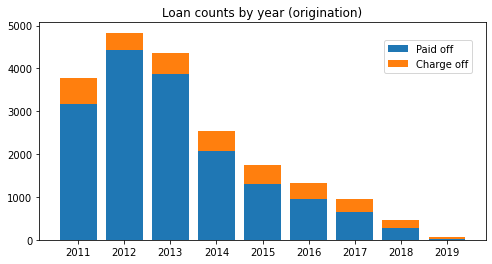

In [107]:
fig, ax = plt.subplots(figsize=(8,4))

_ = ax.bar(np.arange(len(df_year_zbc)), 
            height=df_year_zbc['Paid off'], 
            label='Paid off')
_ = ax.bar(np.arange(len(df_year_zbc)), 
            height=df_year_zbc['Charge off'], 
           bottom=df_year_zbc['Paid off'], 
            label='Charge off')
_ = ax.set_xticks(np.arange(len(df_year_zbc)))
_ = ax.set_xticklabels(df_year_zbc.index)
_ = ax.legend(loc='upper right', 
          bbox_to_anchor=(0.98, 0.94))
_ = ax.set_title("Loan counts by year (origination)")

#### Loan age at termination

In [65]:
print("Loan age at termination of the loan")
df_zb_row.groupby('zero_bal_code')['loan_age'].agg(['mean', 'std']).rename(mapping_zb_code)

Loan age at termination of the loan


,mean,std
zero_bal_code,,
Paid off,46.041375,28.662311
Charge off,41.911552,20.706510


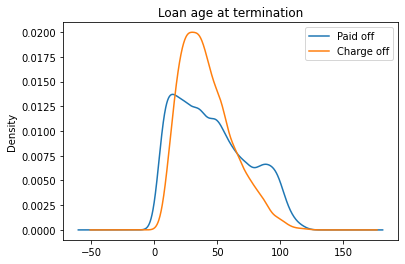

In [66]:
fig, ax = plt.subplots(figsize=(6,4))
for label, _df in df_zb_row.groupby('zero_bal_code'):
    _df['loan_age'].plot(kind="kde", ax=ax, label=mapping_zb_code[label])
plt.legend()
_ = ax.set_title("Loan age at termination")

#### Credit score at loan origination

In [67]:
print("Credit score at loan origination")
df_zb_row.groupby('zero_bal_code')['o_credit_score'].agg(['mean', 'std']).rename(mapping_zb_code)

Credit score at loan origination


,mean,std
zero_bal_code,,
Paid off,758.043587,40.771630
Charge off,726.593562,47.283873


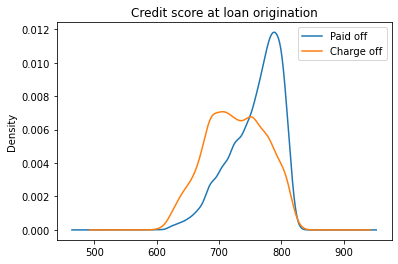

In [68]:
fig, ax = plt.subplots(figsize=(6,4))
for label, _df in df_zb_row.groupby('zero_bal_code'):
    _df['o_credit_score'].plot(kind="kde", ax=ax, label=mapping_zb_code[label])
plt.legend()
_ = ax.set_title("Credit score at loan origination")

#### Loan purpose

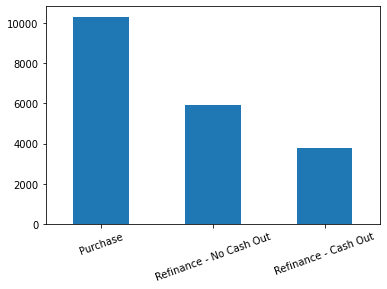

In [69]:
fig, ax = plt.subplots(figsize=(6,4))
df_zb_row['o_purp'].value_counts().plot(kind='bar', ax=ax)
_ = ax.set_xticks(np.arange(3))
_ = ax.set_xticklabels(['Purchase',
                        'Refinance - No Cash Out', 
                        'Refinance - Cash Out'], Rotation=20)

#### Loan count by state

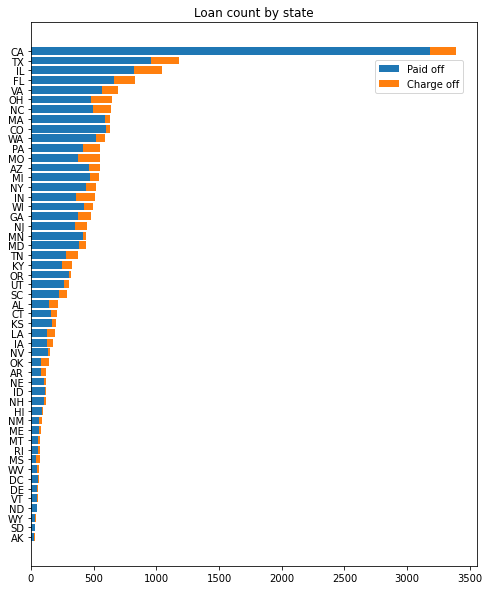

In [70]:
fig, ax = plt.subplots(figsize=(8,10))
# np.array(df_zb_row.loc[df_zb_row['zero_bal_code']==0, 'o_prop_st'].value_counts())
df_st_zbc = pd.crosstab(index=df_zb_row['o_prop_st'], columns=df_zb_row['zero_bal_code'])
df_st_zbc.rename(columns={0: 'Paid off', 1: 'Charge off'}, inplace=True)
df_st_zbc['sum_'] = df_st_zbc['Paid off']+df_st_zbc['Charge off']
df_st_zbc.sort_values(by='sum_', inplace=True)
df_st_zbc.drop(columns=['sum_'], inplace=True)
# df_st_zbc
_ = ax.barh(df_st_zbc.index, 
        width=df_st_zbc['Paid off'], 
        label='Paid off')
_ = ax.barh(df_st_zbc.index, 
        width=df_st_zbc['Charge off'], 
        left=df_st_zbc['Paid off'], 
        label='Charge off')
_ = ax.legend(loc='upper right', 
          bbox_to_anchor=(0.98, 0.94))
_ = ax.set_title("Loan count by state")

#### House price index 

In [71]:
dir_hpi = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/house_index_history/HPI_PO_state.xls'
df_hpi = pd.read_excel(dir_hpi)
df_hpi['st_rep_yr_qtr'] = df_hpi['state']+'_'+df_hpi['yr'].apply(lambda x: str(x)[-2:])+'Q'+df_hpi['qtr'].apply(lambda x: str(x))
df_hpi.drop(columns=['Warning', 'index_nsa'], inplace=True)
df_hpi.rename(columns={'index_sa': 'hpi'}, inplace=True)
df_hpi.reset_index(inplace=True, drop=True)
df_hpi.sort_values(by=['state', 'yr', 'qtr'], inplace=True)
# df_hpi.drop(columns=['state', 'yr', 'qtr'], inplace=True)
df_hpi['per'] = df_hpi['yr'].astype(str) + 'Q' +df_hpi['qtr'].astype(str)
df_hpi['per'] = pd.to_datetime(df_hpi['per'])
df_hpi

,state,yr,qtr,hpi,st_rep_yr_qtr,per
0,AK,1991,1,100.00,AK_91Q1,1991-01-01
1,AK,1991,2,100.41,AK_91Q2,1991-04-01
2,AK,1991,3,101.33,AK_91Q3,1991-07-01
3,AK,1991,4,102.35,AK_91Q4,1991-10-01
4,AK,1992,1,102.68,AK_92Q1,1992-01-01
...,...,...,...,...,...,...
6166,WY,2020,1,376.17,WY_20Q1,2020-01-01
6167,WY,2020,2,374.26,WY_20Q2,2020-04-01
6168,WY,2020,3,383.05,WY_20Q3,2020-07-01
6169,WY,2020,4,395.14,WY_20Q4,2020-10-01


Text(0.5, 1.0, 'House price index')

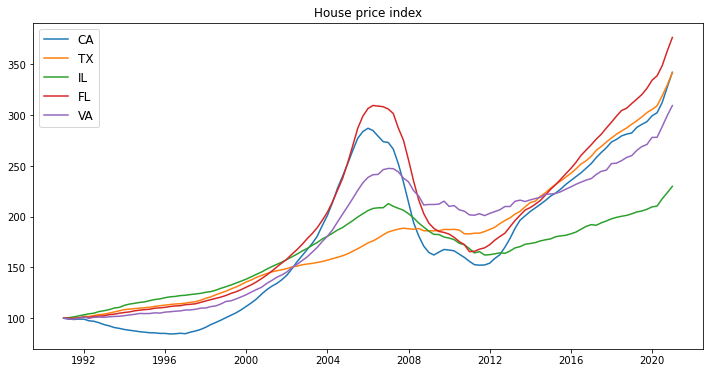

In [72]:
fig, ax = plt.subplots(figsize=(12, 6))
for st in selected_states:
    # print(st)
    df_hpi_st = df_hpi.loc[df_hpi['state']==st, :]
    ax.plot(df_hpi_st['per'], df_hpi_st['hpi'], label=st)
ax.legend(fontsize=12)
ax.set_title("House price index")

#### Unemployment rate history

In [73]:
startyears = [2000, 2010, 2020]
endyears = [2009, 2019, 2021]
# dir_ue = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_2011_2020.csv'
df_ue_list = []
for startyear, endyear in zip(startyears, endyears):
    dir_ue = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_{startyear}_{endyear}.csv'.format(startyear=startyear, 
                                                                                                                                                    endyear=endyear)
    print(dir_ue)
    df_ue = pd.read_csv(dir_ue)
    df_ue_list.append(df_ue)

df_ue = pd.concat(df_ue_list, ignore_index=True)  
# df_ue.drop(columns=['series_id', 'year', 'month', 'st', 'rep_period'], inplace=True)
df_ue.drop(columns=['series_id', 'rep_period'], inplace=True)
df_ue['per'] = df_ue['year'].astype(str)+'-'+df_ue['month'].astype(str).apply(lambda x: x[-2:])
df_ue['per'] = pd.to_datetime(df_ue['per'])
df_ue.head()


/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_2000_2009.csv
/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_2010_2019.csv
/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_2020_2021.csv


,year,month,ue_rate,st,st_rep_period,per
0,2009,M12,11.1,AL,AL_200912,2009-12-01
1,2009,M11,11.0,AL,AL_200911,2009-11-01
2,2009,M10,10.9,AL,AL_200910,2009-10-01
3,2009,M09,10.8,AL,AL_200909,2009-09-01
4,2009,M08,10.6,AL,AL_200908,2009-08-01


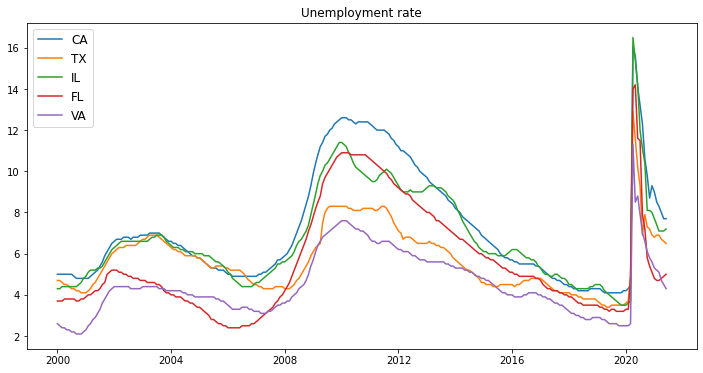

In [74]:
fig, ax = plt.subplots(figsize=(12, 6))
for st in selected_states:
    # print(st)
    df_ue_st = df_ue.loc[df_ue['st']==st, :].sort_values(by='per')
    ax.plot(df_ue_st['per'], df_ue_st['ue_rate'], label=st)
_ = ax.legend(fontsize=12)
_ = ax.set_title("Unemployment rate")


#### State Leve Mortgage Performance Statistics
https://www.fhfa.gov/DataTools/Downloads/Pages/National-Mortgage-Database-Aggregate-Data.aspx

In [75]:
dir_st_co_dlq = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/FRED_mortgage_rate_data/State_Level_Mortgage_Performance_Statistics.xlsx'
df_list = []
for st in us_states:
    try:
        df_st_co_dlq = pd.read_excel(dir_st_co_dlq, 
                                    sheet_name=st, 
                                    skiprows=4,
                                    header=1,
                                    skipfooter=2)
        df_st_co_dlq['st_rep_yr_qtr'] = st+'_'+df_st_co_dlq['Quarter'].astype(str).apply(lambda x: x[-4:])
        df_list.append(df_st_co_dlq)
        # break
    except:
        pass

df_st_co_dlq = pd.concat(df_list, ignore_index=True)  
df_st_co_dlq.drop(columns=['Percent in Forbearance'], inplace=True)
df_st_co_dlq.rename(columns={'Percent 30 or 60 Days Past Due Date': 'pct_3060dpd', 
                             'Percent 90 to 180 Days Past Due Date': 'pct_90180dpd', 
                             'Percent in the Process of Foreclosure, Bankruptcy, or Deed in Lieu': 'pct_fcl'}, 
                    inplace=True)
df_st_co_dlq.dropna(axis=0, inplace=True)
df_st_co_dlq['per'] = pd.to_datetime(df_st_co_dlq['Quarter'])
df_st_co_dlq['state'] = df_st_co_dlq['st_rep_yr_qtr'].apply(lambda x: x[:2])

df_st_co_dlq.head()


,Quarter,pct_3060dpd,pct_90180dpd,pct_fcl,st_rep_yr_qtr,per,state
0,2002Q1,2.8,1.2,3.2,ID_02Q1,2002-01-01,ID
1,2002Q2,2.4,1.1,3.2,ID_02Q2,2002-04-01,ID
2,2002Q3,2.8,1.2,3.3,ID_02Q3,2002-07-01,ID
3,2002Q4,3.6,1.1,3.7,ID_02Q4,2002-10-01,ID
4,2003Q1,3.4,1.2,3.7,ID_03Q1,2003-01-01,ID


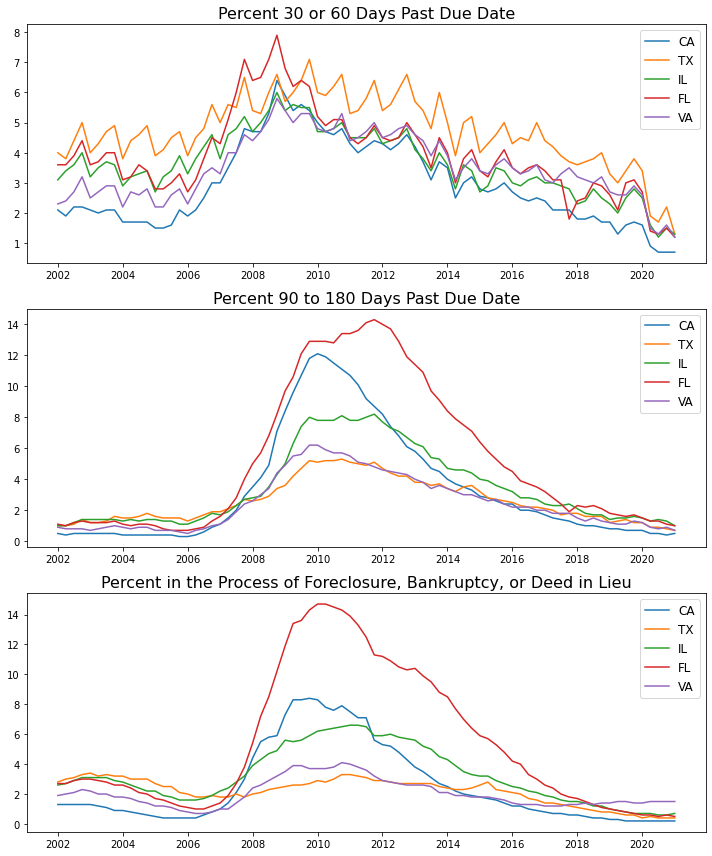

In [76]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
for st in selected_states:
    df_ = df_st_co_dlq.loc[df_st_co_dlq['state']==st, :].sort_values(by='per')
    ax[0].plot(df_['per'], df_['pct_3060dpd'], label=st)
    ax[1].plot(df_['per'], df_['pct_90180dpd'], label=st)
    ax[2].plot(df_['per'], df_['pct_fcl'], label=st)

## a) 30 or 60 days past due date, 
## b) 90 to 180 days past due date, 
## c) in the process of foreclosure, bankruptcy, or deed-in-lieu.
titles = ['Percent 30 or 60 Days Past Due Date', 
          'Percent 90 to 180 Days Past Due Date', 
          'Percent in the Process of Foreclosure, Bankruptcy, or Deed in Lieu']
for i in range(3):
    _ = ax[i].legend(fontsize=12)
    _ = ax[i].set_title(titles[i], fontsize=16)

plt.tight_layout()

#### Charge-Off/Delinquency Rate

Charge-Off Rate on Single Family Residential Mortgages, Booked in Domestic Offices, Top 100 Banks Ranked by Assets
https://fred.stlouisfed.org/series/CORSFRMT100N

Delinquency Rate Rate on Single-Family Residential Mortgages, Booked in Domestic Offices, All Commercial Banks
https://fred.stlouisfed.org/series/DRSFRMACBS

In [77]:
dir_chgoff = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/FRED_mortgage_rate_data/Charge-Off Rate on Single Family Residential Mortgages, Booked in Domestic Offices, Top 100 Banks Ranked by Assets.xlsx'
df_chgoff = pd.read_excel(dir_chgoff)
df_chgoff['observation_date'] = pd.to_datetime(df_chgoff['observation_date'])
df_chgoff['rep_yr_qtr'] = df_chgoff['observation_date'].apply(lambda x: str(x.year)[-2:])+'Q'+df_chgoff['observation_date'].apply(lambda x: str(x.quarter))
df_chgoff.rename(columns={'CORSFRMT100S': 'charge_off_rate'}, inplace=True)
# plt.plot(df_chgoff['observation_date'], df_chgoff['charge_off_rate'], label='charge_off_rate')
# plt.legend()

# df_chgoff.drop(columns=['observation_date'], inplace=True)
# df_chgoff.head()


In [78]:
dir_dlq = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/FRED_mortgage_rate_data/Delinquency Rate on Single-Family Residential Mortgages, Booked in Domestic Offices, All Commercial Banks.xlsx'
df_dlq = pd.read_excel(dir_dlq)
df_dlq['observation_date'] = pd.to_datetime(df_dlq['observation_date'])
df_dlq['rep_yr_qtr'] = df_dlq['observation_date'].apply(lambda x: str(x.year)[-2:])+'Q'+df_dlq['observation_date'].apply(lambda x: str(x.quarter))
df_dlq.rename(columns={'DRSFRMACBS': 'dlq_rate'}, inplace=True)
# plt.plot(df_dlq['observation_date'], df_dlq['dlq_rate'], label='dlq_rate')
# plt.legend()

# df_dlq.drop(columns=['observation_date'], inplace=True)
# df_dlq.head()


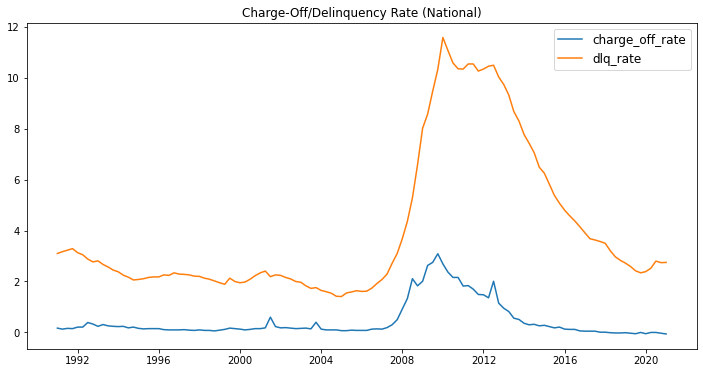

In [79]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_chgoff['observation_date'], df_chgoff['charge_off_rate'], label='charge_off_rate')
ax.plot(df_dlq['observation_date'], df_dlq['dlq_rate'], label='dlq_rate')

_ = ax.legend(fontsize=12)
_ = ax.set_title("Charge-Off/Delinquency Rate (National)")

#### 30-Year Fixed Rate Mortgage Average in the United States
https://fred.stlouisfed.org/series/MORTGAGE30US

In [80]:
dir_mort_rate = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/FRED_mortgage_rate_data/30-Year Fixed Rate Mortgage Average in the United States.xlsx'
df_mort_rate = pd.read_excel(dir_mort_rate)
df_mort_rate['observation_date'] = pd.to_datetime(df_mort_rate['observation_date'])
df_mort_rate.sort_values(by='observation_date', inplace=True)
df_mort_rate['rep_period'] = df_mort_rate['observation_date'].dt.year.astype(str)+df_mort_rate['observation_date'].apply(lambda x: '0'+str(x.month) if x.month<10 else str(x.month))
df_mort_rate = df_mort_rate.groupby('rep_period').apply(lambda x: x.tail(1))
df_mort_rate.reset_index(inplace=True, drop=True)
df_mort_rate.rename(columns={'MORTGAGE30US': 'avg_frm'}, inplace=True)
# plt.plot(df_mort_rate['observation_date'], df_mort_rate['avg_frm'], label='avg_frm')
# plt.legend()

# df_mort_rate.drop(columns=['observation_date'], inplace=True)
# df_mort_rate.head()

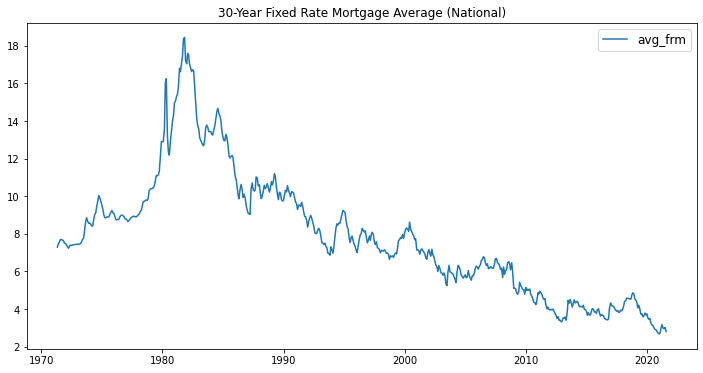

In [81]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_mort_rate['observation_date'], df_mort_rate['avg_frm'], label='avg_frm')

_ = ax.legend(fontsize=12)
_ = ax.set_title("30-Year Fixed Rate Mortgage Average (National)")